### Feature extraction

In [ ]:
###This notebook contains the clustering for museum descriptions, the extarction of pice innfromation and opening hours, the mapping of translationset ID museums to events  

In [2]:
import json
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

import string 
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import html.parser as html
import nltk
from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import cross_val_predict

import string
import bs4 as bs  
import urllib.request  
import re  

In [3]:
os.chdir("/Users/julia/Documents/University of Amsterdam/DSP - Data System Project/museum.nl Data/museumnl_taxonomy")
filename = 'musea2.csv'

df_asset = pd.read_csv(filename, encoding='utf-8')

In [4]:
#extract price from musea csv
df_M = df_asset = pd.read_csv(filename, encoding='utf-8').drop_duplicates(subset=['publicName'])
len(df_M)


505

In [5]:
data = df_M['publicName'].tolist()
data_p = df_M['prizes'].tolist()

In [6]:
len(data)

505

In [7]:
enum_instace = enumerate(data_p)

In [8]:
def getstring():
    key = next(enum_instace)
    return str(key)

In [9]:
def extractprice():
    try:
        ap = getstring()
        z = ap.index("'description': 'Volwassenen'")
        x = z-6
        y = z-2
        price = ap[x:y]
        return price
    except ValueError:
        price = 0
        return price

In [10]:
prices = []

In [11]:
for i in range(504):
    price = extractprice()
    prices += [price]

In [12]:
df_1 = pd.DataFrame(list(zip(data, prices )),
                      columns = ['publicName', 'ticketprice'])
df_1[df_1['ticketprice'] == 0].count()

publicName     31
ticketprice    31
dtype: int64

#### export prices to csv

In [30]:
df_1.head()

,publicName,ticketprice
0,Afrika Museum,15.0
1,Agrarisch Museum Westerhem,4.5
2,Airborne Museum at Hartenstein,15.0
3,Allard Pierson,10.0
4,Amsterdam Pipe Museum,12.0


### Getting opening Hours

In [13]:
data = df_M['publicName'].tolist()
data_p = df_M['openingPeriods'].tolist()

In [14]:
#can be easily concatinated later on
len(data), len(data_p)

(505, 505)

In [33]:
enum_instace = enumerate(data_p)


In [34]:
def getstring():
    key = next(enum_instace)
    return str(key)

In [35]:
str_lst = df_M.iloc[1]['openingPeriods']

In [36]:
#check where the times can be found
str_lst = df_M.iloc[300]['openingPeriods']
str_lst
z = str_lst.index("day': 'zondag'")
end_3 = z + 55
start_3 = end_3 - 5

end_2 = z + 74
start_2 = end_2 - 5
print(str_lst[start_3:end_3] + '-' + str_lst[start_2:end_2] )

11:00-17:00


In [37]:
#in case they need to be deleted again
del zaterdagen
del zondagen

NameError: name 'zaterdagen' is not defined

In [38]:
#initalize list
zaterdagen = []
zondagen = []

In [39]:
#function to extract times
def extracttimes():
    try:
        ap = getstring()
        z = ap.index("day': 'zaterdag'")
        end_1 = z + 57
        start_1 = end_1 - 5

        end_2 = z + 76
        start_2 = end_2 - 5
        zaterdag = ap[start_1:end_1] + '-' + ap[start_2:end_2] 
        
        f = ap.index("day': 'zondag'")
        end_3 = f + 55
        start_3 = end_3 - 5

        end_4 = f + 74
        start_4 = end_4 - 5
        zondag = ap[start_3:end_3] + '-' + ap[start_4:end_4] 
        
        return zaterdag, zondag
    
    except ValueError:
        zaterdag, zondag = 0, 0
        return zaterdag, zondag

In [40]:
for i in range(496):
    zaterdag, zondag = extracttimes()
    zaterdagen += [zaterdag]
    zondagen += [zondag]

In [41]:
df_2 = pd.DataFrame(list(zip(zaterdagen, zondagen )),
                      columns = ['zaterdagen', 'zondagen'])

In [42]:
df_2['zaterdagen'] = df_2['zaterdagen']\
                            .str.replace("', 't-sOpen", '0')\
                            .str.strip()
df_2['zondagen'] = df_2['zondagen']\
                            .str.replace("', 't-sOpen", '0')\
                            .str.strip()

In [43]:
df_2.head()

,zaterdagen,zondagen
0,10:00-17:00,10:00-17:00
1,0,0
2,10:00-17:00,10:00-17:00
3,10:00-17:00,10:00-17:00
4,12:00-18:00,0


### export with price data

In [44]:
open_price = pd.concat([df_1, df_2], axis=1)
open_price.head()

,publicName,ticketprice,zaterdagen,zondagen
0,Afrika Museum,15.0,10:00-17:00,10:00-17:00
1,Agrarisch Museum Westerhem,4.5,0,0
2,Airborne Museum at Hartenstein,15.0,10:00-17:00,10:00-17:00
3,Allard Pierson,10.0,10:00-17:00,10:00-17:00
4,Amsterdam Pipe Museum,12.0,12:00-18:00,0


In [45]:
#export to csv
open_price.to_csv('musea_openh_tprice.csv', encoding='utf-8', index=False)

### Clustering

In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import sys

In [198]:
#!pip install lux-api
#import lux
#del sys.modules["lux"]

In [199]:
os.chdir("/Users/julia/Documents/University of Amsterdam/DSP - Data System Project/museum.nl Data/museumnl_taxonomy")
filename = 'pronkstukken.csv'

df_show = pd.read_csv(filename, encoding='utf-8')

In [200]:
df_subshow = df_show[['museumName', 'museumId', 'description']]

In [201]:
df_subshow.head()
length =df_subshow['museumId'].unique()
len(length)

261

In [202]:
##result df was created in the following section, 
df_descrip = result[['publicName', 'museumId', 'description_event']]

#unstack the rows of event descriptions into columns
df_ds =df_descrip.groupby('museumId')['description_event'].apply(lambda df: df.reset_index(drop=True)).unstack()

#assuming that many of the columns won't be needed since most museums just have few events
df_ds.drop(df_ds.iloc[:, 6:23], axis=1, inplace=True)

# then resetting index and ready to be merged
df_ds.reset_index(level=0, inplace=True)

#removing any other access columns
df_ds.drop(df_ds.columns[7], axis=1, inplace=True)


In [203]:
#the df with event descriptions
len(df_ds)

320

In [204]:
#do similar mapping operations with showpiece df
#df_subshow.head() sort_values
df_sp = df_subshow.groupby('museumId')['description'].apply(lambda df: df.reset_index(drop=True)).unstack()
df_sp.reset_index(level=0, inplace=True)
df_sp.drop(df_sp.iloc[:, 3:8], axis=1, inplace=True)

In [205]:
df_ds.head()

,museumId,0,1,2,3,4,5
0,00a12e8d-f885-4a76-b0af-08d7f60b9c3e,Graag nodigen we je uit voor een exclusief bez...,**Beeld en Geluid start binnenkort een nieuw a...,NaN,NaN,NaN,NaN
1,0138b762-ab30-45b0-afd2-08d7f60b9c3e,Kunst hangt meestal aan de muur en doet niets....,In de expositie Gestolde beweging bewonder je ...,Op de zolder van het Gorcums Museum vind je de...,NaN,NaN,NaN
2,02b3e2a4-4f99-4c53-b09b-08d7f60b9c3e,Perfectie in vorm en kleur. Dat zocht de 100 j...,Beeldend kunstenaar Michiel van Bakel richt zi...,Koos Buster werkt voornamelijk in keramiek. Vo...,Het Nationaal Glasmuseum neemt deel aan de vie...,NaN,NaN
3,02e34b39-92b5-44a7-b145-08d7f60b9c3e,Teylers Museum heeft de belangrijkste collecti...,Ter gelegenheid van 75 jaar vrijheid vind je i...,Maak je eigen dinosaurus tijdens de leuke work...,Tijdens deze familieworkshop maak jij je favor...,Tijdens de spannende speurtocht Dinomakers ont...,*Dinomakers* is een familietentoonstelling die...
4,0407f434-cc20-4236-b06d-08d7f60b9c3e,In het herdenkingsjaar 2020 zie je in Museum N...,NaN,NaN,NaN,NaN,NaN


In [206]:
df_sp = df_sp.rename(columns={ 0 : "show_1", 1: "show_2" })

In [207]:
df_ds = df_ds.rename(columns={ 0 : "event_1", 1: "event_2", 2 : "event_3", 3: "event_4", 4:"event_5", 5:"event_6" })

In [208]:
df_m =df_M[['publicName','id', 'teaser', 'metaDescription', 'description']]
df_m = df_m.rename(columns= {'id': 'museumId'})

In [209]:
#merging the evenementen, musea and showpiece description
df_merg = pd.merge(df_m, df_ds, how="outer", on='museumId', validate='one_to_one')
df_merg = pd.merge(df_merg, df_sp, how="outer", on='museumId', validate='one_to_one')

In [210]:
df_merg.head()

,publicName,museumId,teaser,metaDescription,description,event_1,event_2,event_3,event_4,event_5,event_6,show_1,show_2
0,Afrika Museum,af1f674a-f04d-4527-af8c-08d7f60b9c3e,Het Afrika Museum in Berg en Dal is een binnen...,In het Afrika Museum vind je Afrikaanse object...,### Afrikaanse religies\nHet museum is opgeric...,Er werken meer dan 2 miljoen kindarbeiders op ...,Hedendaagse fotografen uit Afrika laten in het...,Vergroot deze zomer je kennis over Afrika in h...,NaN,NaN,NaN,Deze 19e-eeuwse armband is een erfstuk van een...,NaN
1,Agrarisch Museum Westerhem,38612c20-29d2-4905-af8d-08d7f60b9c3e,Agrarisch Museum Westerhem is vanwege de coron...,Agrarisch Museum Westerhem is gevestigd in een...,### Stolpboerderij \nAgrarisch Museum Westerhe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Airborne Museum at Hartenstein,c804a952-fafc-41ae-af8e-08d7f60b9c3e,Het Airbornemuseum bevindt zich in de prachtig...,In het Airborne Museum beleef je de Slag om Ar...,In de nieuwe opzet van het museum vormt Villa ...,Ga jij mee ondergronds? Stap in Airborne Museu...,In de ondergrondse Airborne Experience ga je t...,Journalist en schrijver Ad van Liempt neemt je...,Ontdek in de kinderaudiotour van het Airborne ...,NaN,NaN,Villa Hartenstein is het hart van de historisc...,NaN
3,Allard Pierson,bc2cae4b-6dbf-4392-af8f-08d7f60b9c3e,Het Allard Pierson deelt de collecties van de ...,Het Allard Pierson deelt de collecties van de ...,### Tijdreis\nIn de vaste museumpresentatie *V...,"Met zijn kromme, korte beentjes, zijn uitgesto...",Van handelaren uit het Assyrische Rijk tot the...,Hier maakt Het Nieuwe Instituut maakt van bezo...,NaN,NaN,NaN,"Palmyra, de Syrische 'stad van de duizend zuil...",NaN
4,Amsterdam Pipe Museum,ac61a4c2-53d2-4ce6-af90-08d7f60b9c3e,"De vroegste pijp ter wereld, de vorstenpijp ui...",Vuurtje? Het Amsterdam Pipe Museum geeft een o...,Het Amsterdam Pipe Museum beheert een collecti...,NaN,NaN,NaN,NaN,NaN,NaN,Deze pijpenkop is maar liefst 22 cm hoog! Dat ...,NaN


In [211]:
#merging all text columns together
cols = ['teaser', 'metaDescription', 'description', 'event_1', 'event_2', 'event_3', 'event_4', 'event_5', 'event_6', 'show_1', 'show_2']
df_merg['combined'] = df_merg[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [212]:
cols = ['show_1', 'show_2']
df_merg['combined_asset'] = df_merg[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [213]:
df_merg = df_merg[df_merg['combined_asset'].notna()]
#df_merg.dropna(inplace=True)
#df_merg.head(50)

In [214]:
#Stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("dutch")


In [215]:
#clean up description column
#df_merg.combined = df_merg.combined.fillna('')
#df_merg.combined = df_merg.combined_asset.str.lower()
#df_merg.combined = df_merg.combined.replace('\n',' ', regex=True)
#df_merg.combined = df_merg.combined.replace(regex=r'[^0-9a-zA-Z]+', value=' ')
#df_merg.combined = df_merg.combined.str.strip()

In [216]:
df_merg.iloc[302]['combined']

'In NEMO Science Museum ontdek je hoe fascinerend wetenschap en technologie zijn. 5 verdiepingen vol tentoonstellingen en experimenten laten jong en oud ervaren hoe bijzonder alledaagse dingen zijn._In NEMO Science Museum ontdek je hoe fascinerend wetenschap en technologie zijn. Leuk voor jong én oud!_### Bijzonder alledaags\nNEMO Science Museum is het grootste science museum van Nederland en is voor iedereen die nieuwsgierig is. Iedere bezoeker, van jong tot oud, kan hier zelf de wereld van wetenschap en technologie ontdekken. NEMO neemt je mee in de wereld van die alledaagse dingen die toch heel bijzonder zijn. Ontdek bijvoorbeeld hoe bruggen werken, waarom je soms dingen ziet die er niet zijn en hoe bliksem ontstaat door zelf aan de slag te gaan met de interactieve opstellingen. \n\n### Workshops en demonstraties\nWorkshops, filmpjes, experimenten en demonstraties maken je NEMO-dag compleet. Een knetterende trui of een regenboog: na een bezoek aan NEMO zal je met nieuwe ogen naar de

In [217]:
#!pip install stop-words

In [218]:
from stop_words import get_stop_words

stopword_lst = get_stop_words('dutch')

In [219]:
import re

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #filtered_words = [word for word in tokens if word not in get_stop_words('dutch')]
    
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[0-9a-zA-Z]', token):
            filtered_tokens.append(token)
            
        if token in stopword_lst:
            filtered_tokens.remove(token) 
            
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [220]:
#just to check
#df_merg['tok_stem'] = df_merg.combined.apply(tokenize_and_stem).values

In [221]:
#print(tfidf_vectorizer.get_feature_names())

In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
#take out stopwords part to use snowball stemmer as defined above
#min_df=0.1, max_df=0.9,
tfidf_vectorizer = TfidfVectorizer(max_features=2000, 
                                   max_df=0.8, use_idf=True, stop_words=stopword_lst,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [223]:
tfidf_matrix =  tfidf_vectorizer.fit_transform([x for x in df_merg['combined']])

In [224]:
tfidf_matrix.shape

(507, 2000)

In [225]:
del lst
del combined_lst

In [226]:
lst = [x for x in df_merg['combined']]
combined_lst = []

In [227]:
for i in lst:
    token = tokenize_and_stem(i)
    t = ' '.join(str(e) for e in token)
    combined_lst += [t]

In [228]:
len(combined_lst)

507

In [229]:
#df_merg.loc[df_merg.cluster == 5][['publicName']]

In [230]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [231]:
from sklearn.cluster import KMeans

true_k=20
# Create a KMeans object, change nclusters umber 
km = KMeans(n_clusters=true_k)
#max_iter=200, n_init=10 
# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster
df_merg['cluster'] = clusters
df_merg['cluster'].value_counts()

0     83
9     55
16    36
3     36
10    34
11    26
5     24
1     22
15    22
4     21
2     20
13    19
17    17
19    16
8     15
12    15
14    15
7     14
18    11
6      6
Name: cluster, dtype: int64

In [63]:
# Import cosine_similarity to calculate similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

#from sklearn.metrics.pairwise import euclidean_distance

In [64]:
# Import modules for dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

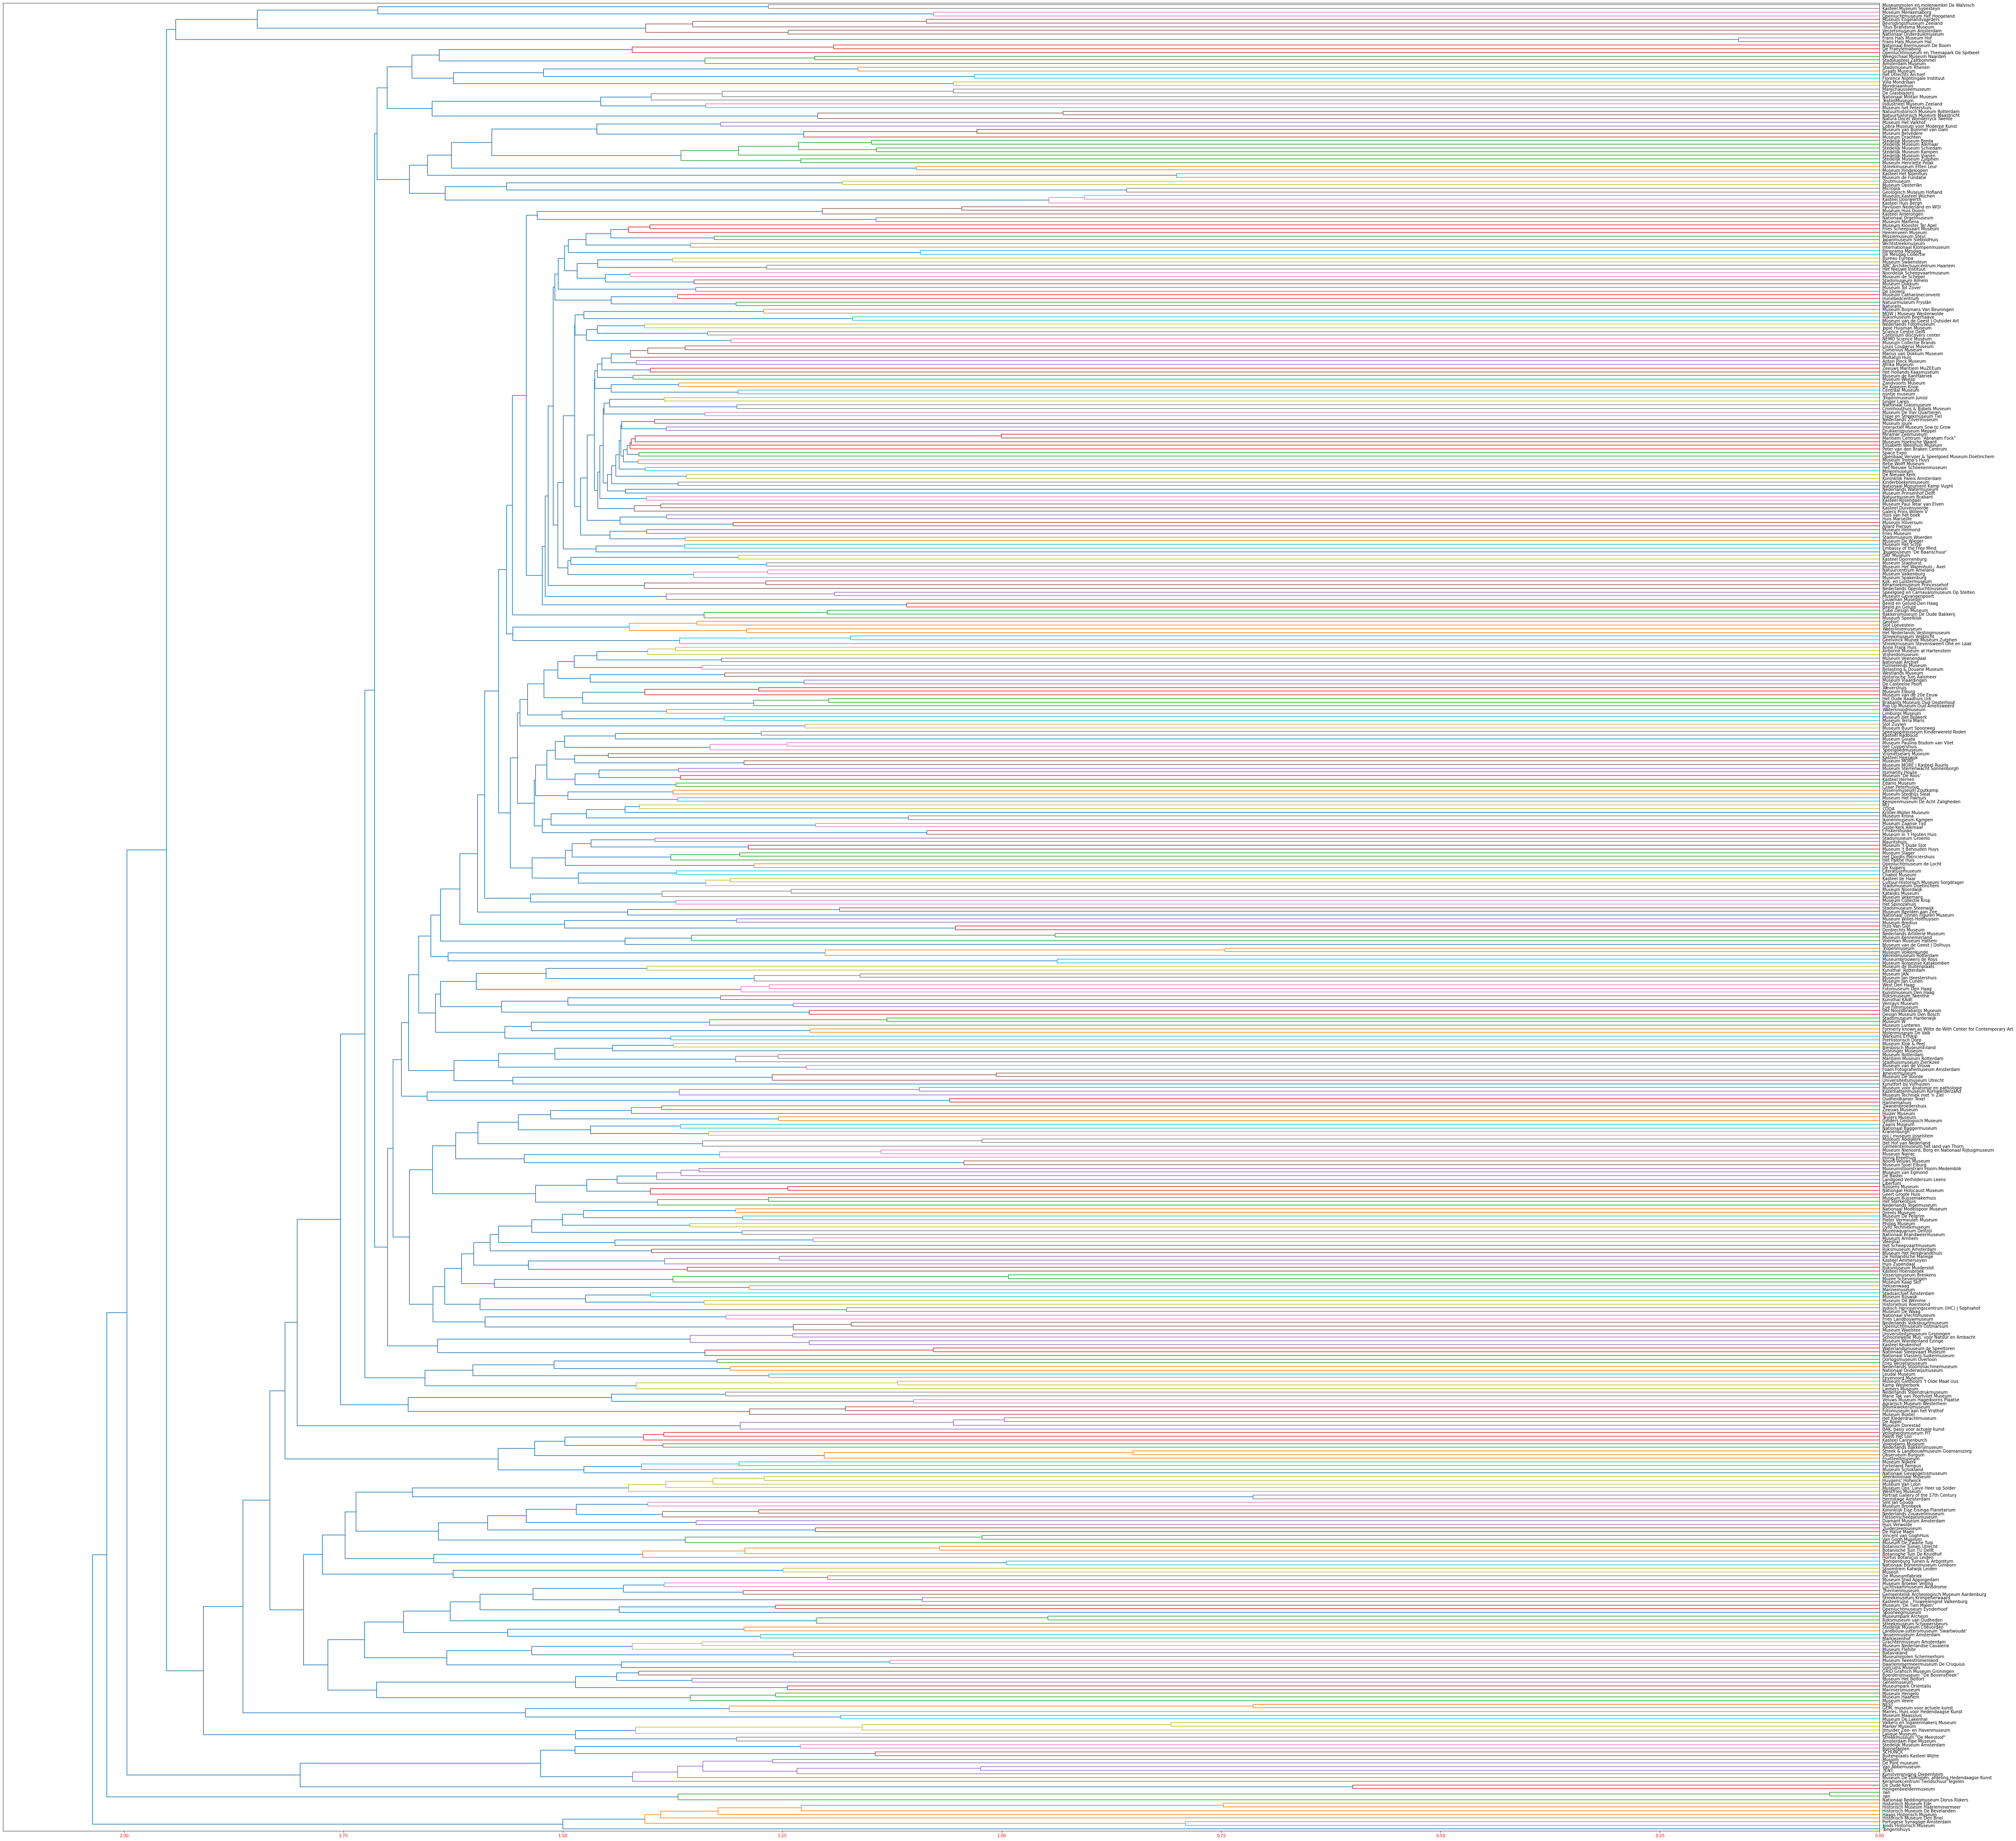

In [544]:
# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using publicName as label column
dendrogram_ = dendrogram(mergings, orientation="left",
               labels=[x for x in df_merg['publicName']],leaf_font_size=10)
                         #leaf_rotation=90, 

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(80, 80)
plt.show()

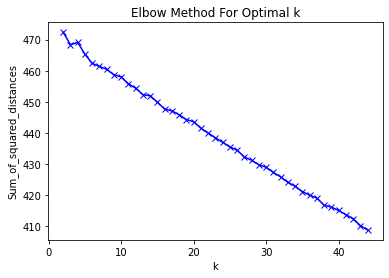

In [644]:
Sum_of_squared_distances = []
K = range(2,45)
for k in K:
    km = KMeans(n_clusters=k, max_iter=10, n_init=10)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [233]:
#!pip install wordcloud
labels = df_merg['cluster'].tolist()
title = df_merg['publicName'].tolist()

In [234]:
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                      title  cluster
186                         Museum De Wemme        0
239                         Slot Loevestein        0
242                        Museum Speelklok        0
243                  Museum Stad Appingedam        0
453                       Vechtstreekmuseum        0
..                                      ...      ...
176                      Museum de Fundatie       19
202                  Museum Henriette Polak       19
261  Museummolen en molenwinkel De Walvisch       19
353                Stedelijk Museum Zutphen       19
348                Stedelijk Museum Alkmaar       19

[507 rows x 2 columns]


Cluster: 0
Titles
                                            CODA
                         Museum Collectie Brands
                   Cromhouthuis & Bijbels Museum
                                      DAF Museum
                               Dordrechts Museum
                                   Drents Museum
                       Elisabeth Weeshuis Museum
                     Flipje en Streekmuseum Tiel
    Gemeentelijk Archeologisch Museum Aardenburg
               Gemeentemuseum het land van Thorn
                            Het Utrechts Archief
                 Historisch Museum De Bevelanden
                              De Casteelse Poort
                                  Hunebedcentrum
                                 Katwijks Museum
                                 Limburgs Museum
                           Louis Couperus Museum
                                  Louwman Museum
                        mij | museum ijsselstein
                                Museum Abdijkerk
  

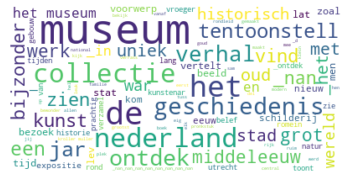

Cluster: 1
Titles
              Anton Pieck Museum
  Brabants Museum Oud Oosterhout
                     Molenmuseum
        Embassy of the Free Mind
                  Eye Filmmuseum
 Foam Fotografiemuseum Amsterdam
            Het Nieuwe Instituut
        Kunstfort bij Vijfhuizen
                Literatuurmuseum
               Huis van het boek
            Natuurmuseum Brabant
                 Beeld en Geluid
    Nederlands Artillerie Museum
      Paviljoen Nederland en WOI
       Het Nieuwe Schoenenmuseum
                      Space Expo
 ABC Architectuurcentrum Haarlem
                   Bureau Europa
Veluws Museum Hagedoorns Plaatse
              Kinderboekenmuseum
              Cube Design Museum
                             NaN


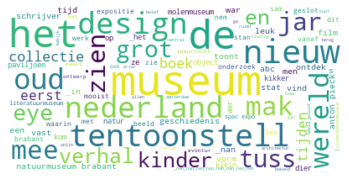

Cluster: 2
Titles
             Betje Wolff Museum
              Geert Groote Huis
                Het Spinozahuis
              Museum de Scheper
                Het Palthe Huis
                  Huis Van Gijn
                  Huis Verwolde
                 Huis Zypendaal
               De Fraeylemaborg
                 Multatuli Huis
                 Museum De Waag
             Museum Klok & Peel
                Museum Van Loon
             Museum Zaanse Tijd
Museum Paulina Bisdom van Vliet
                Speelgoedmuseum
    Landgoed Verhildersum Leens
    Nederlands Volksbuurtmuseum
      Stoomtrein Katwijk Leiden
     Touwmuseum 'De Baanschuur'


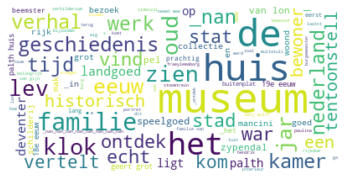

Cluster: 3
Titles
               Airborne Museum at Hartenstein
                              Anne Frank Huis
                       Biesbosch MuseumEiland
                              Het Cuypershuis
                                 Edams Museum
                              Kamp Westerbork
                               Spoorwegmuseum
                               Humanity House
              Kazemattenmuseum Kornwerderzand
            Museum Giethoorn 't Olde Maat Uus
                               Museum Hengelo
                   Museum Romeinse Katakomben
                          Museum Sjoel Elburg
                          Museum van de Vrouw
                            Museum van Egmond
                           Muzee Scheveningen
                              Vrijheidsmuseum
                   Nationaal Gevangenismuseum
                         Nationaal Glasmuseum
                    Nationaal Militair Museum
                Nationaal Monument Kamp Vught
                

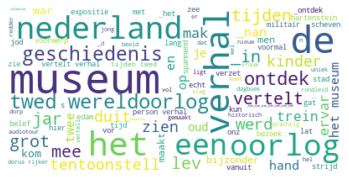

Cluster: 4
Titles
                           Chabot Museum
                        Fruitteeltmuseum
                   Heiligenbeeldenmuseum
               Historische Tuin Aalsmeer
                 Hortus Botanicus Leiden
                 Japanmuseum SieboldHuis
                          Liemers Museum
               Maritiem Museum Rotterdam
                      Missiemuseum Steyl
                        Museum Rotterdam
          Natura Docet Wonderryck Twente
      Natuurhistorisch Museum Maastricht
       Natuurhistorisch Museum Rotterdam
                    Natuurmuseum Fryslân
                   Nederlands Fotomuseum
                          Philips Museum
                       Purmerends Museum
Schoonewelle Mus. voor Natuur en Ambacht
                                 GeoFort
                        Museum 'De Roos'
                 Pieter Vermeulen Museum


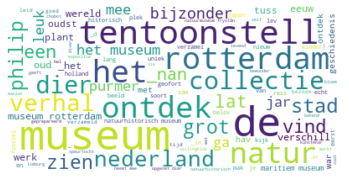

Cluster: 5
Titles
                    Kasteel Doornenburg
                     Kasteel Ammersoyen
                    Kasteel Cannenburch
                        Kasteel de Haar
                      Kasteel Doorwerth
                   Kasteel Duivenvoorde
                         Kasteel Hernen
                     Kasteel Hoensbroek
                     Kasteel Huis Bergh
               Kasteel Museum Sypesteyn
                      Kasteel Rosendael
           Museum MORE | Kasteel Ruurlo
                      Kasteel Keukenhof
                  Kasteel Het Nijenhuis
                         Museum Helmond
                 Museum Kasteel Wijchen
                        Rijssens Museum
                            Slot Zuylen
                      Kasteel Amerongen
                       Kasteel Heeswijk
                        Kasteel Radboud
Kasteelruïne - Fluweelengrot Valkenburg
                 Rijksmuseum Muiderslot
                             Zoutmuseum


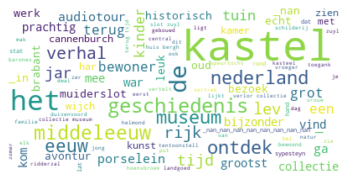

Cluster: 6
Titles
                    Comenius Museum
    Maritiem Centrum "Abraham Fock"
                        Mauritshuis
                     Museum Martena
Koninklijk Eise Eisinga Planetarium
            Stadskasteel Zaltbommel


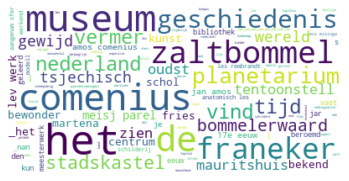

Cluster: 7
Titles
                       Czaar Peterhuisje
                  Drukkerijmuseum Meppel
        Historisch Museum Haarlemmermeer
                   Kijk en Luistermuseum
              Openluchtmuseum Eynderhoof
                Openluchtmuseum de Locht
               Nederlands Bakkerijmuseum
              Nederlands Openluchtmuseum
Openluchtmuseum en Themapark De Spitkeet
           Openluchtmuseum Het Hoogeland
               Openluchtmuseum Ootmarsum
                      PreHistorisch Dorp
                      Museum Het Bolwerk
                      Museum Menkemaborg


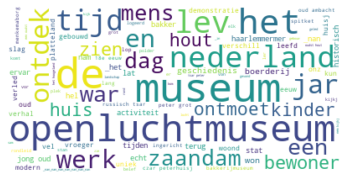

Cluster: 8
Titles
                        Bonnefanten
                Fotomuseum Den Haag
                               KM21
            Haags Historisch Museum
Marres, Huis voor Hedendaagse Kunst
                 Museum De Lakenhal
                         Museum JAN
                  Museum Valkenburg
                  Museum Swaensteyn
                Museum 't Oude Slot
               Kunstmuseum Den Haag
                   Museum Jan Cunen
                   Museum Maassluis
                               NEST
                      West Den Haag


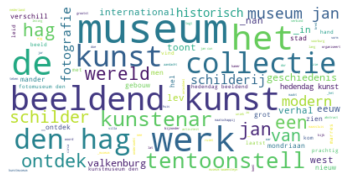

Cluster: 9
Titles
           Amsterdam Pipe Museum
      Luchtvaartmuseum Aviodrome
 Bakkerijmuseum De Oude Bakkerij
                   De Halve Maen
      Continium discovery center
       Geologisch Museum Hofland
           Het Scheepvaartmuseum
                 Het Sterkenhuis
               Huygens' Hofwijck
    Internationaal Klompenmuseum
 Kempenmuseum De Acht Zaligheden
                    Marinemuseum
                 Mariniersmuseum
                        Micropia
                          Museon
                     De Looierij
              Marechausseemuseum
        Museum In 't Houten Huis
                Museum Kaap Skil
    Museum Nederlandse Cavalerie
               Museum Spakenburg
          Museum van de 20e Eeuw
                    Museum Veere
                De Museumfabriek
 Museumstoomtram Hoorn-Medemblik
          Nationaal Baggermuseum
           Natuurcentrum Ameland
   Nederlands Stoommachinemuseum
          Nederlands Watermuseum
             NEMO Science

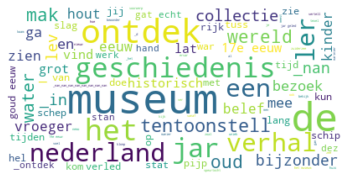

Cluster: 10
Titles
            Boerderijmuseum ''De Bovenstreek''
          Cultuur-Historisch Museum Sorgdrager
                               Museum Waelstee
                            Grote Kerk Alkmaar
                Florence Nightingale Instituut
                                   Hannemahuis
                                      Museum W
                     Het Dordts Patriciërshuis
                       Joods Historisch Museum
           Landbouw-Juttersmuseum 'Swartwoude'
                                Museum Bredius
                         Museum Buurt Spoorweg
                               De Koperen Knop
                               Museum Dorestad
                         Het Oude Raadhuis Urk
                               Museum Lunteren
                                 Museum Slager
                          Museum Stedhûs Sleat
                       Museum 't Behouden Huys
                     Nationaal Brandweermuseum
Openbaar Vervoer & Speelgoed Museum Doeti

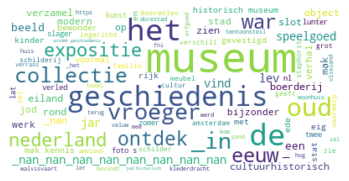

Cluster: 11
Titles
          Belasting & Douane Museum
          Botanische Tuinen Utrecht
                    De Glasblazerij
                De Mesdag Collectie
      Museum van de Geest | Dolhuys
                     Gorcums Museum
                  Museum Huis Doorn
                Ikonenmuseum Kampen
Keramiekcentrum Tiendschuur Tegelen
         Kunstvereniging Diepenheim
           Marius van Dokkum Museum
        Fotomuseum aan het Vrijthof
             Museum Beelden aan Zee
             Museum de Buitenplaats
                    Museum Drachten
                    Museum Rijswijk
 Museum voor anatomie en pathologie
        Buitenplaats Kasteel Wijlre
                       De Oude Kerk
                MU Hybrid Art House
              Rijksmuseum Amsterdam
                               TENT
     Trompenburg Tuinen & Arboretum
                     Van Abbemuseum
                             Musiom
                    Villa Mondriaan


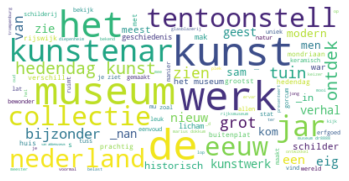

Cluster: 12
Titles
 Botanische Tuin De Kruidhof
        Fries Landbouwmuseum
                Fries Museum
    Fries Scheepvaart Museum
         Fries Verzetsmuseum
           Heerenveen Museum
        Jopie Huisman Museum
       Museum Bussemakerhuis
          Museum Hindeloopen
                Museum Joure
            Museum Opsterlân
 Nationaal Modelspoor Museum
Noordelijk Scheepvaartmuseum
       Museum de Kantfabriek
IJmuider Zee- en Havenmuseum


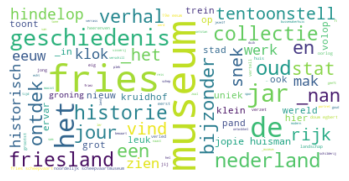

Cluster: 13
Titles
                      Allard Pierson
                 Hermitage Amsterdam
               Museum Collectie Krop
         Koninklijk Paleis Amsterdam
                        Markiezenhof
                    Museum Het Schip
            Museum Willet-Holthuysen
                      De Nieuwe Kerk
                      Paleis Het Loo
              Stadsarchief Amsterdam
                    Amsterdam Museum
            Diamant Museum Amsterdam
            Grachtenmuseum Amsterdam
              Het Klederdrachtmuseum
              Tassenmuseum Amsterdam
               De Hollandsche Manege
Portrait Gallery of the 17th Century
             Luther Museum Amsterdam
                                 NaN


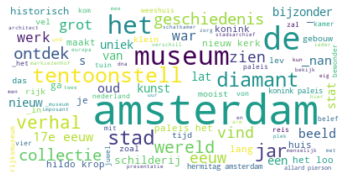

Cluster: 14
Titles
   Agrarisch Museum Westerhem
    Gelders Geologisch Museum
                Graafs Museum
               Huis Marseille
            Miramar Zeemuseum
       Museum 'De Tien Malen'
           Museum Het Pakhuis
        Museum het Petershuis
          Museum Kennemerland
    Museum Wierdenland Ezinge
            Museum Veenendaal
                Leudal Museum
Nationaal Bomenmuseum Gimborn
Universiteitsmuseum Groningen
               Huis van Hilde


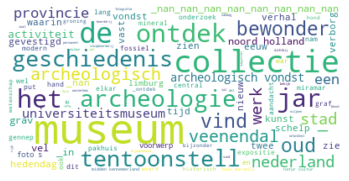

Cluster: 15
Titles
                 Bevrijdingsmuseum Zeeland
                               Geniemuseum
            GRID Grafisch Museum Groningen
                     Het Hof van Nederland
                               De Kuiperij
                       Molenmuseum De Valk
                        Museum Terra Maris
                        Museum Vlaardingen
                              Museum Weesp
                     Museumpark Orientalis
                  Nederlands Zouavenmuseum
                  Stadhuismuseum Zierikzee
               Museum Het Warenhuis - Axel
                Industrieel Museum Zeeland
                          Waterliniemuseum
                             Zeeuws Museum
                        Museum Het Belfort
                        Museum Sow to Grow
                   Museumbrouwerij de Roos
                 Nederlands Pluimveemuseum
Museum Vincentre | Van Gogh Village Nuenen
              Storyworld | Forum Groningen


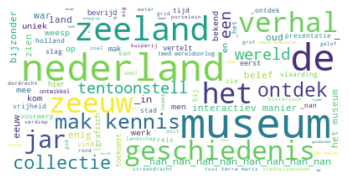

Cluster: 16
Titles
                                     Afrika Museum
                     BAK, basis voor actuele kunst
    Museum De Domijnen, afdeling Hedendaagse Kunst
                                    De Pont museum
                           Design Museum Den Bosch
                                  Groninger Museum
                                     Kunsthal KAdE
                               Kunsthal  Rotterdam
                   Marie Tak van Poortvliet Museum
                                       Museum MORE
                                     Mondriaanhuis
                          MOW | Museum Westerwolde
                                  Museum Belvédère
                                  Museum De Wieger
                             Museum De Zwarte Tulp
                          Museum Het Rembrandthuis
                                Museum Het Valkhof
                                  Museum Hilversum
                           Museum Jan Heestershuis
            

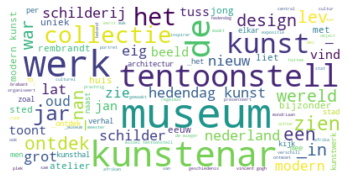

Cluster: 17
Titles
         Flessenscheepjesmuseum
        Het Hollands Kaasmuseum
   Het Nederlands Vestingmuseum
          Historiehuis Roermond
                  Marker Museum
         Museum Broeker Veiling
               Museum De Voorde
             Museum Volkenkunde
        Nederlands Zilvermuseum
                Panorama Mesdag
          Rijksmuseum Boerhaave
Museum Sterrenwacht Sonnenborgh
                     Heksenwaag
               Museum Tot Zover
                   Tropenmuseum
            Tropenmuseum Junior
         Wereldmuseum Rotterdam


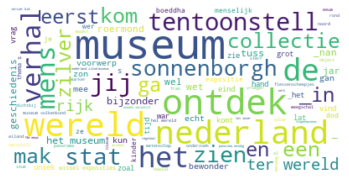

Cluster: 18
Titles
   Botanische Tuin TU Delft
     Galerij Prins Willem V
Historisch Museum Den Briel
Keramiekmuseum Princessehof
Museum Paul Tetar van Elven
    Museum Prinsenhof Delft
       Science Centre Delft
    Stedelijk Museum Vianen
      Frans Hals Museum Hal
      Frans Hals Museum Hof
      Veiligheidsmuseum PIT


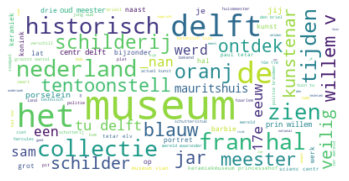

Cluster: 19
Titles
                              De Appel
       Cobra Museum voor Moderne Kunst
                       Museum Bronbeek
                    Museum de Fundatie
                Museum Henriette Polak
Museummolen en molenwinkel De Walvisch
                         Jenevermuseum
                    Stadsmuseum Almelo
                Stadsmuseum Harderwijk
              Stedelijk Museum Alkmaar
                Stedelijk Museum Breda
            Stedelijk Museum Coevorden
               Stedelijk Museum Kampen
              Stedelijk Museum Zutphen
            Stedelijk Museum Amsterdam
             Stedelijk Museum Schiedam


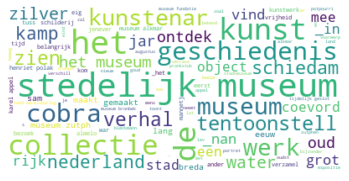

In [235]:
from wordcloud import WordCloud
df_res={'cluster':clusters,'combined':combined_lst}
df_res=pd.DataFrame(df_res)
for k in range(0,true_k):
    s=df_res[df_res.cluster==k]
    text=s['combined'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki_cl[wiki_cl.cluster==k]['title']         
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [77]:
'''EXPORTING DATA FRAME'''
df_final = df_merg[['publicName', 'museumId', 'cluster']]
df_final.to_csv('description_cluster.csv', encoding='utf-8', index=False)

### Mapping tranlationset ids

In [20]:
os.chdir("/Users/julia/Documents/University of Amsterdam/DSP - Data System Project/museum.nl Data/museumnl_taxonomy")
filename = 'evenementen.csv'

df_events = pd.read_csv(filename, encoding='utf-8')

In [21]:
#dropping duplicate museums
df_M = df_asset.drop_duplicates(subset=['publicName'])
len(df_M)

505

In [22]:
#selecting relevant columns from asset csv
sub_mu = pd.concat([df_M['publicName'], df_M['translationSetId'], df_M['id'], df_M['teaser'], df_M['metaDescription'], df_M['description']], axis=1)

In [23]:
sub_mu = sub_mu.rename(columns={"translationSetId": "translationSetId_museum", "id" : "museumId"})

In [24]:
#df_events.iloc[9]['description']
#df_asset.info()

In [25]:
#selecting the relevent columns from events
df_ev = df_events[['name', 'eventType', 'targetAges', 'description', 'translationSetId', 'id', 'museumId', 'museumName']]

In [26]:
df_ev =df_ev.rename(columns={"name": "event_name", "translationSetId" : "translationSetId_event", 'description': 'description_event' })

In [27]:
sub_mu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 694
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   publicName               505 non-null    object
 1   translationSetId_museum  505 non-null    object
 2   museumId                 505 non-null    object
 3   teaser                   505 non-null    object
 4   metaDescription          505 non-null    object
 5   description              502 non-null    object
dtypes: object(6)
memory usage: 27.6+ KB


In [28]:
#hence, there will be 76 museums without events
len(df_ev['museumId'].unique())

420

In [29]:
#one to many relationship, where one musuem is assiged to several events
#matching the id column from museum csv and museumId from evenementen csv
result = pd.merge(sub_mu, df_ev, how="outer", on='museumId', validate='one_to_many')

In [30]:
#dropping events and museum which could not find a match in the other set
result.dropna(inplace=True)
#result = result[result['publicName'].notna()]
#results

In [31]:
#checking real quick whether the one to many match worked, by selecting a museum which is supposed to have several evet types
result[result['museumName'].str.contains("Museum Het Schip")]

,publicName,translationSetId_museum,museumId,teaser,metaDescription,description,event_name,eventType,targetAges,description_event,translationSetId_event,id,museumName
416,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,Bruno Taut: De fantasie voorbij,Exhibition,[],De Amsterdamse School-architecten hadden hun v...,a0e02faf-bc8b-436c-a5b9-26da24ded30b,ed1693d0-49f4-47ee-fbff-08d81dd03c20,Museum Het Schip
417,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,Collectie straatmeubilair,Exhibition,[],Straatmeubilair is overal om ons heen. Het is ...,371c4d75-3478-454b-b5f8-48bfbe175131,6147b6a0-916b-4cfc-fc01-08d81dd03c20,Museum Het Schip
418,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,Het Eiland,Exhibition,[],Het Eiland is een stedenbouwkundig project van...,2b64fb74-6261-4680-b2d9-2ca327f34c22,8542e786-ca6c-4fbf-fc03-08d81dd03c20,Museum Het Schip
419,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,"Interactieve theaterlezing | ""Wauw, wat een ge...",Workshop,"['FiveToEightYears', 'NineToTwelveYears']",Help mee om huizen voor de armen in de stad te...,73b95b5e-6faa-46b8-a3d1-39584cab4717,24390422-b81e-41ec-0be8-08d827282f66,Museum Het Schip
420,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,Midzomer Mokum Ambachtenworkshops,Workshop,"['FiveToEightYears', 'NineToTwelveYears', 'Thi...",Museum Het Schip organiseert in samenwerking m...,d6ef32d9-a070-42a5-8f8f-1585c9e9e656,72eeb71e-21ff-4c64-0bf5-08d827282f66,Museum Het Schip
421,Museum Het Schip,eba73114-b030-49d1-9108-e60ea8670b3a,a365e5b1-5860-4195-b05b-08d7f60b9c3e,Museum Het Schip bevindt zich in een fantasiev...,Museum Het Schip bevindt zich in een fantasiev...,### Michel de Klerk\nHet Schip is het bekendst...,Busexcursie Amsterdamse School,Activity,[],"Een 2,5 uur durende busexcursie langs de bouw-...",0c80c771-2822-4e0a-b76f-685c06a4ce71,bc23c1a9-6be6-4ceb-f113-08d82d698de8,Museum Het Schip


#### convert translationsetIDs to csv

In [32]:
#data frame is still quite large, but the results csv has the translation set ids matched (919)

df_mapping = result[['publicName', 'translationSetId_museum', 'museumId', 'translationSetId_event', 'id' ]]
#df_mapping
#to csv? drop all exce
df_description = result[['publicName', 'museumId', 'teaser', 'metaDescription', 'description', 'description_event']]

In [33]:
#there are 10 different event types
result['eventType'].unique()

array(['Exhibition', 'Activity', 'Audiotour', 'Other', 'Workshop',
       'Childrensparty', 'ScavengerHunt', 'Lecture', 'Tour', 'Event'],
      dtype=object)

In [34]:
len(result)

919

In [35]:
df_mapping.to_csv('musea_mapping.csv', encoding='utf-8', index=False)

### One-hot encode categories

In [67]:
#One hot encode, where each mseum evet combination is 1, so there are several vectors for one museum
one_hot_cat = result.eventType.str.get_dummies(', ')
output = pd.concat([result, one_hot_cat], axis=1)
output.head(3)
#output.drop(['eventType'], axis=1, inplace=True)

,publicName,translationSetId_museum,museumId,teaser,metaDescription,description,event_name,eventType,targetAges,description_event,...,Activity,Audiotour,Childrensparty,Event,Exhibition,Lecture,Other,ScavengerHunt,Tour,Workshop
0,Afrika Museum,b5023390-ced1-4210-a14c-23c349b2ee15,af1f674a-f04d-4527-af8c-08d7f60b9c3e,Het Afrika Museum in Berg en Dal is een binnen...,In het Afrika Museum vind je Afrikaanse object...,### Afrikaanse religies\nHet museum is opgeric...,BITTER Chocolate Stories,Exhibition,"['NineToTwelveYears', 'ThirteenToEighteenYears']",Er werken meer dan 2 miljoen kindarbeiders op ...,...,0,0,0,0,1,0,0,0,0,0
1,Afrika Museum,b5023390-ced1-4210-a14c-23c349b2ee15,af1f674a-f04d-4527-af8c-08d7f60b9c3e,Het Afrika Museum in Berg en Dal is een binnen...,In het Afrika Museum vind je Afrikaanse object...,### Afrikaanse religies\nHet museum is opgeric...,World Press Photo: Door de lens van,Exhibition,[],Hedendaagse fotografen uit Afrika laten in het...,...,0,0,0,0,1,0,0,0,0,0
2,Afrika Museum,b5023390-ced1-4210-a14c-23c349b2ee15,af1f674a-f04d-4527-af8c-08d7f60b9c3e,Het Afrika Museum in Berg en Dal is een binnen...,In het Afrika Museum vind je Afrikaanse object...,### Afrikaanse religies\nHet museum is opgeric...,Het levensgrote doolhofspel,Activity,"['ZeroToFourYears', 'FiveToEightYears', 'NineT...",Vergroot deze zomer je kennis over Afrika in h...,...,1,0,0,0,0,0,0,0,0,0


In [68]:
#now we need to get a single vector per museum
test_df = output[['publicName', 'Activity', 'Audiotour', 'Childrensparty', 'Event', 'Exhibition', 'Lecture', 'Other', 'ScavengerHunt', 'Tour', 'Workshop']]

In [69]:
#summing over the museum names, so that there is just one vector per museum
test = test_df.groupby(by=['publicName']).sum()
test

,Activity,Audiotour,Childrensparty,Event,Exhibition,Lecture,Other,ScavengerHunt,Tour,Workshop
publicName,,,,,,,,,,
ABC Architectuurcentrum Haarlem,0,0,0,0,0,0,1,0,0,0
Afrika Museum,1,0,0,0,2,0,0,0,0,0
Airborne Museum at Hartenstein,0,2,0,0,2,0,0,0,0,0
Allard Pierson,0,0,0,0,1,0,1,0,0,1
Amsterdam Museum,0,0,0,0,5,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
Zeeuws Maritiem MuZEEum,0,0,1,0,3,0,1,1,0,0
Zeeuws Museum,0,0,0,0,4,0,0,0,0,0
Zuiderzeemuseum,2,0,0,1,2,0,0,0,0,0


In [70]:
#reset index to have museum names as another column
test.reset_index(level=0, inplace=True)

In [71]:
#mask values above 1 into one-hot-encode vectors
test_2 = test.iloc[:,1:10]
test_3 = test_2.mask(test_2 > 1, 1)
test_3

,Activity,Audiotour,Childrensparty,Event,Exhibition,Lecture,Other,ScavengerHunt,Tour
0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0
3,0,0,0,0,1,0,1,0,0
4,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
315,0,0,1,0,1,0,1,1,0
316,0,0,0,0,1,0,0,0,0
317,1,0,0,1,1,0,0,0,0
318,0,0,0,0,1,0,0,0,0


#### export one-hot encoded categories to csv

In [72]:
#create final dataframe of one hot encoded categories
test_4 = test.iloc[:,0]
test_5 = pd.concat([test_4, test_3], axis=1)


### one hot encoding age  groups

In [73]:
import re
regex = re.compile(r'\([^\(\)]+\)')
import ast
from ast import literal_eval

In [74]:
age = result[['publicName', 'targetAges']]
age.head(10)


,publicName,targetAges
0,Afrika Museum,"['NineToTwelveYears', 'ThirteenToEighteenYears']"
1,Afrika Museum,[]
2,Afrika Museum,"['ZeroToFourYears', 'FiveToEightYears', 'NineT..."
4,Airborne Museum at Hartenstein,"['NineToTwelveYears', 'ThirteenToEighteenYears']"
5,Airborne Museum at Hartenstein,[]
6,Airborne Museum at Hartenstein,[]
7,Airborne Museum at Hartenstein,['NineToTwelveYears']
8,Allard Pierson,"['ZeroToFourYears', 'FiveToEightYears', 'NineT..."
9,Allard Pierson,[]
10,Allard Pierson,"['FiveToEightYears', 'NineToTwelveYears', 'Thi..."


In [75]:
age['ZeroToFourYears'] = 0
age['FiveToEightYears'] = 0
age['NineToTwelveYears'] = 0
age['ThirteenToEighteenYears'] = 0

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [76]:
age.head(10)

,publicName,targetAges,ZeroToFourYears,FiveToEightYears,NineToTwelveYears,ThirteenToEighteenYears
0,Afrika Museum,"['NineToTwelveYears', 'ThirteenToEighteenYears']",0,0,0,0
1,Afrika Museum,[],0,0,0,0
2,Afrika Museum,"['ZeroToFourYears', 'FiveToEightYears', 'NineT...",0,0,0,0
4,Airborne Museum at Hartenstein,"['NineToTwelveYears', 'ThirteenToEighteenYears']",0,0,0,0
5,Airborne Museum at Hartenstein,[],0,0,0,0
6,Airborne Museum at Hartenstein,[],0,0,0,0
7,Airborne Museum at Hartenstein,['NineToTwelveYears'],0,0,0,0
8,Allard Pierson,"['ZeroToFourYears', 'FiveToEightYears', 'NineT...",0,0,0,0
9,Allard Pierson,[],0,0,0,0
10,Allard Pierson,"['FiveToEightYears', 'NineToTwelveYears', 'Thi...",0,0,0,0


In [77]:
#recylced code from mark to split the targetAge
def create_true_falses_multiplication(row):
    data = literal_eval(row['targetAges'])

    # These are the vector updates based on the facilities column
    if 'ZeroToFourYears' in data:
        row['ZeroToFourYears'] = 1
    else:
        row['ZeroToFourYears'] = 0
    if 'FiveToEightYears' in data:
        row['FiveToEightYears'] = 1
    else:
        row['FiveToEightYears'] = 0
    if 'NineToTwelveYears' in data:
        row['NineToTwelveYears'] = 1
    else:
        row['NineToTwelveYears'] = 0
    if 'ThirteenToEighteenYears' in data:
        row['ThirteenToEighteenYears'] = 1
    else:
        row['ThirteenToEighteenYears'] = 0


    # These are the vector updates based on the categories found in the external museum data file

    return row


In [78]:
#apply the function to one-hot encode vectors
df_x = age.apply(create_true_falses_multiplication, axis=1)

In [79]:
#drop age column
df_x.pop('targetAges')

0        ['NineToTwelveYears', 'ThirteenToEighteenYears']
1                                                      []
2       ['ZeroToFourYears', 'FiveToEightYears', 'NineT...
4        ['NineToTwelveYears', 'ThirteenToEighteenYears']
5                                                      []
                              ...                        
1087                                                   []
1089                                                   []
1092                                                   []
1093                                                   []
1094                                                   []
Name: targetAges, Length: 919, dtype: object

In [80]:
df_test = df_x.groupby(by=['publicName']).sum()
df_test

,ZeroToFourYears,FiveToEightYears,NineToTwelveYears,ThirteenToEighteenYears
publicName,,,,
ABC Architectuurcentrum Haarlem,1,1,1,1
Afrika Museum,1,1,2,2
Airborne Museum at Hartenstein,0,0,2,1
Allard Pierson,1,2,2,2
Amsterdam Museum,1,2,2,1
...,...,...,...,...
Zeeuws Maritiem MuZEEum,2,3,3,2
Zeeuws Museum,1,1,1,1
Zuiderzeemuseum,2,3,3,2


In [81]:
df_test.reset_index(level=0, inplace=True)
df_test1 = df_test.iloc[:,1:4]
df_test2 = df_test1.mask(df_test1 > 1, 1)
df_test4 = df_test.iloc[:,0]
df_agecat = pd.concat([df_test4, df_test2], axis=1)
df_agecat

,publicName,ZeroToFourYears,FiveToEightYears,NineToTwelveYears
0,ABC Architectuurcentrum Haarlem,1,1,1
1,Afrika Museum,1,1,1
2,Airborne Museum at Hartenstein,0,0,1
3,Allard Pierson,1,1,1
4,Amsterdam Museum,1,1,1
...,...,...,...,...
315,Zeeuws Maritiem MuZEEum,1,1,1
316,Zeeuws Museum,1,1,1
317,Zuiderzeemuseum,1,1,1
318,mij | museum ijsselstein,0,0,0


#### export age groups and types

In [82]:
#test_5 is event type one hot data frame
df_age_type = pd.merge(df_agecat, test_5, how="outer", on='publicName', validate='one_to_one')

In [83]:
df_age_type.head()

,publicName,ZeroToFourYears,FiveToEightYears,NineToTwelveYears,Activity,Audiotour,Childrensparty,Event,Exhibition,Lecture,Other,ScavengerHunt,Tour
0,ABC Architectuurcentrum Haarlem,1,1,1,0,0,0,0,0,0,1,0,0
1,Afrika Museum,1,1,1,1,0,0,0,1,0,0,0,0
2,Airborne Museum at Hartenstein,0,0,1,0,1,0,0,1,0,0,0,0
3,Allard Pierson,1,1,1,0,0,0,0,1,0,1,0,0
4,Amsterdam Museum,1,1,1,0,0,0,0,1,0,0,1,1


In [84]:
df_age_type.to_csv('musea_age_type.csv', encoding='utf-8', index=False)